# Path planning application

## Imports and constants

In [26]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt, patches
from matplotlib.lines import Line2D

from utils import (
    ROOM_DIM,
    AUDIO_PATH,
    encode,
    load_model,
    create_room,
    get_doa_MUSIC,
    normalize,
    get_CNN_prediction,
    create_observations,
)

# Model

In [27]:
class ModelPredictor:
    def __init__(self, model, source_loc, centre_mic, colour):
        self.room = None
        self.microphones = None
        self.centre_mic = centre_mic
        self.success = False
        self.source_loc = source_loc
        self.colour = colour
        self.model_name = model
        self.fs = 16000

        # AI related
        self.steps = 0

        if self.model_name == "CNN":
            self.encoder = encode()
            self.model = load_model("../models/saved_model", compile=True)

    def get_room(self, signal, ax):
        self.room, self.microphones = create_room(
            signal, self.fs, self.source_loc, self.centre_mic
        )
        ax.add_patch(
            patches.Circle(
                (self.centre_mic[0], self.centre_mic[1]),
                radius=0.05,
                edgecolor=self.colour,
                facecolor="none",
                linewidth=2,
            )
        )
    
    def update_source_loc(self, source_loc):
        self.source_loc = source_loc

    def get_pred(self, ax):
        pred = 0

        if self.model_name == "MUSIC":
            pred = get_doa_MUSIC(self.room, self.microphones, self.fs)

        elif self.model_name == "CNN":
            data = self.room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            X = create_observations(data, self.fs)
            pred = get_CNN_prediction(X, self.model, self.encoder)

        else:
            pass

        self.process(ax, pred)

        if not self.success:
            self.steps += 1

    def process(self, ax, pred):
        if (
            self.source_loc[0] - 0.15 < self.centre_mic[0] < self.source_loc[0] + 0.15
            and self.source_loc[1] - 0.15
            < self.centre_mic[1]
            < self.source_loc[1] + 0.15
        ):
            self.success = True
        elif 0.2 > self.centre_mic[0] > 4.8 or 0.2 > self.centre_mic[1] > 4.8:
            self.success = True
        else:
            self.update_centre(ax, pred)

    def update_centre(self, ax, pred):
        x_align = self.centre_mic[0] + 0.3 * np.cos(pred)
        y_align = self.centre_mic[1] + 0.3 * np.sin(pred)

        if not x_align == False:
            ax.add_patch(
                patches.Arrow(
                    self.centre_mic[0],
                    self.centre_mic[1],
                    0.3 * np.cos(pred),
                    0.3 * np.sin(pred),
                    width=0.1,
                    edgecolor=self.colour,
                    facecolor=self.colour,
                )
            )

            self.centre_mic = [x_align, y_align]


In [28]:
class SoundSource:

    def __init__(
        self,
        source_loc: tuple = (np.random.uniform(0.5, 4.5), np.random.uniform(0.5, 4.5)),
        initial_direction: tuple = (np.random.uniform(-1, 1), np.random.uniform(-1, 1)),
    ):
        self.source_loc = source_loc
        self.colour = "black"
        self.position: list = [source_loc[0], source_loc[1]]
        self.speed = 0.35
        self.direction = initial_direction

    def plot(self, ax):
        ax.add_patch(
            patches.Circle(
                (self.source_loc[0], self.source_loc[1]),
                radius=0.05,
                edgecolor=self.colour,
                facecolor="none",
                linewidth=2,
                label="Sound Source",
            )
        )

    def move(self, ax):
        self.position[0] += self.speed * self.direction[0]
        self.position[1] += self.speed * self.direction[1]

        # Check if the source is within the room
        if self.position[0] < 0.2 or self.position[0] > 4.8:
            self.direction = (-self.direction[0], self.direction[1])

        if self.position[1] < 0.2 or self.position[1] > 4.8:
            self.direction = (self.direction[0], -self.direction[1])

        ax.add_patch(
            patches.Circle(
                (self.position[0], self.position[1]),
                radius=0.05,
                edgecolor=self.colour,
                facecolor="none",
                linewidth=2,
                label="Sound Source",
            )
        )

    def random_move(self, ax) :
        # Shift the direction by +/- 15 degrees
        angle = np.random.uniform(-15, 15)
        angle = np.radians(angle)
        new_direction = (
            self.direction[0] * np.cos(angle) - self.direction[1] * np.sin(angle),
            self.direction[0] * np.sin(angle) + self.direction[1] * np.cos(angle),
        )

        self.direction = new_direction
        self.move(ax)

## Visualization

MUSIC time taken: 0.0021s
370/370 [==============================] - 0s 723us/step
CNN prediction time: 0.3537s
MUSIC time taken: 0.0024s
370/370 [==============================] - 0s 912us/step
CNN prediction time: 0.3988s
MUSIC time taken: 0.0024s
369/369 [==============================] - 0s 790us/step
CNN prediction time: 0.3562s
MUSIC time taken: 0.0022s
369/369 [==============================] - 0s 690us/step
CNN prediction time: 0.3151s
MUSIC time taken: 0.0021s
369/369 [==============================] - 0s 695us/step
CNN prediction time: 0.3175s
MUSIC time taken: 0.0022s
369/369 [==============================] - 0s 691us/step
CNN prediction time: 0.3124s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0020s
MUSIC time taken: 0.0022s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0022s
MUSIC time taken: 0.0021s
MUSIC time taken: 0.0020s
MUSIC time taken: 0.0020s
MUSIC time taken: 0.0024s
MUSIC time taken

/var/folders/_m/3pwm0mlj2rsdd_y3ql1v0fpm0000gn/T/ipykernel_54757/621724412.py:73: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not x_align == False:


ValueError: setting an array element with a sequence.

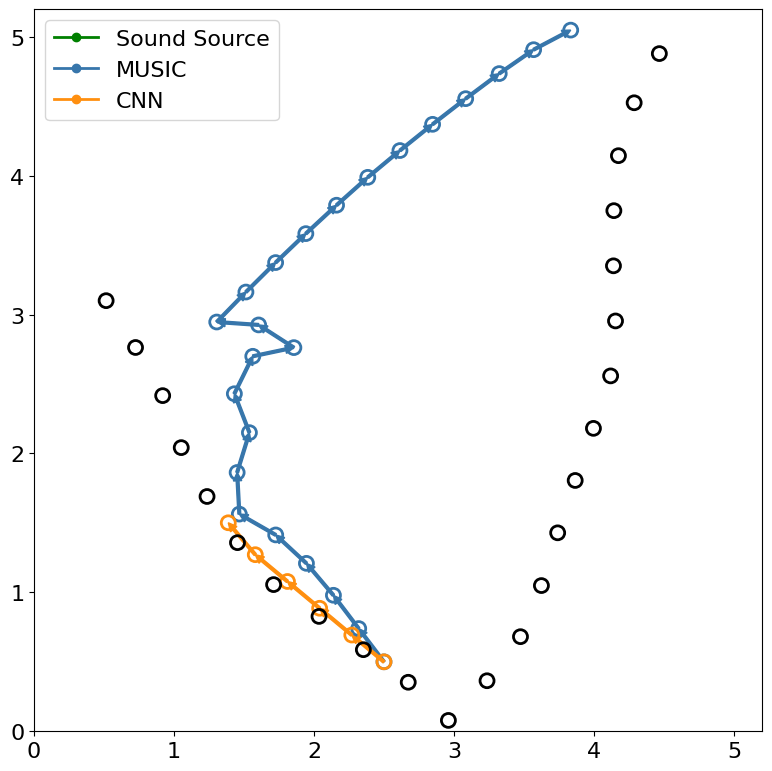

In [29]:
microphones = np.c_[[ROOM_DIM[0]/2-0.1, 0.5, 0], [ROOM_DIM[0]/2+0.1, 0.5, 0]]
# Randomise the sound source location
sound_source = SoundSource()
centre_mic = [2.5, 0.5]

plt.rcParams.update({'figure.figsize': [8,8], 'figure.autolayout': True, 'font.size': 16})
fig, _ = plt.subplots()
ax = plt.gca()
ax.set_xlim([0, 5.2])
ax.set_ylim([0, 5.2])

# Include sound source patch
sound_source.plot(ax)

# Include custom legend
legend_elements = [Line2D([0], [0], marker='o', lw=2, color='green',   label='Sound Source'),
                   Line2D([0], [0], marker='o', lw=2, color='#3776ab', label='MUSIC'),
                   Line2D([0], [0], marker='o', lw=2, color="#ff8f0f", label='CNN')]
ax.legend(handles=legend_elements, loc='upper left')

# Initialize models
MUSIC = ModelPredictor("MUSIC", sound_source.position, centre_mic, "#3776ab")
CNN = ModelPredictor("CNN", sound_source.position, centre_mic, "#ff8f0f")

i = 0
# Generate predictions
while not (MUSIC.success and CNN.success):
    # Generate room
    fs, signal = wavfile.read(AUDIO_PATH)

    if not MUSIC.success:
        MUSIC.update_source_loc(sound_source.position)
        MUSIC.get_room(signal, ax)
        # Locate the sound source
        MUSIC.get_pred(ax)


    if not CNN.success:
        CNN.update_source_loc(sound_source.position)
        CNN.get_room(signal, ax)
        # Locate the sound source
        CNN.get_pred(ax)
    
    # If one of the models fails to locate the sound source, move the sound source

    i += 1
    plt.savefig("../pygame/path_ideal/path_ideal_%02d.png"%i)
    
    if not MUSIC.success or not CNN.success:
        sound_source.random_move(ax)

plt.show()
# Display the number of steps taken
print("MUSIC steps: ", MUSIC.steps)
print("CNN steps: ", CNN.steps)